<a href="https://colab.research.google.com/github/lorenz0leoncin1/project_xgboost/blob/main/XGBoost_BS_Solution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [625]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error
from xgboost import XGBRegressor
df = pd.read_excel("bs_task.xlsx")
print(df.head())
print(df.tail())

        Date  Users  Lockdown_flag  Campaigns_flag
0 2017-01-11      1              0               0
1 2017-01-12      1              0               0
2 2017-01-13      1              0               0
3 2017-01-14      1              0               0
4 2017-01-15      3              0               0
           Date  Users  Lockdown_flag  Campaigns_flag
1597 2021-05-27     16              0               0
1598 2021-05-28     13              0               0
1599 2021-05-29      6              0               0
1600 2021-05-30      4              0               0
1601 2021-05-31      1              0               0


In [626]:
# Assicurati che la colonna Date sia in formato datetime
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

# Creazione delle lag features e rolling average
df['users_lag_1'] = df['Users'].shift(1)
df['users_lag_7'] = df['Users'].shift(7)
df['rolling_mean_7'] = df['Users'].rolling(window=7).mean()


In [627]:
# Supponiamo che il tuo DataFrame sia chiamato df
# Calcola la matrice di correlazione
correlation_matrix = df.corr()

# Seleziona solo le correlazioni con 'Users'
user_correlation = correlation_matrix['Users']

# Filtra le features con correlazione significativa
significant_features = user_correlation[abs(user_correlation) > 0.2]  # Soglia di 0.3, puoi cambiarla

print("Features correlate a 'Users':")
print(significant_features)

# Puoi anche considerare di eliminare le features correlate tra loro per evitare multicollinearità

Features correlate a 'Users':
Users             1.000000
Campaigns_flag    0.223549
users_lag_1       0.550645
users_lag_7       0.504093
rolling_mean_7    0.683357
Name: Users, dtype: float64


In [628]:
# Seleziona le feature e il target
features = ['Campaigns_flag','users_lag_1', 'users_lag_7', 'rolling_mean_7']
target = 'Users'


In [629]:
X = df[features]
y = df[target]

In [630]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)


In [631]:
# Funzione per addestrare il modello e calcolare le metriche
def train_and_evaluate(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)

    mae_train = mean_absolute_error(y_train, y_pred_train)
    rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
    mae_test = mean_absolute_error(y_test, y_pred_test)
    rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))

    return mae_train, rmse_train, mae_test, rmse_test, y_pred_test

In [632]:
# Modello iniziale senza tuning
initial_model = XGBRegressor(objective='reg:squarederror', n_estimators=100, learning_rate=0.1, eval_metric=['rmse','mae'])
mae_train_initial, rmse_train_initial, mae_test_initial, rmse_test_initial, y_pred_test_initial = train_and_evaluate(initial_model, X_train, y_train, X_test, y_test)


In [633]:
print("Risultati iniziali senza tuning:")
print(f'MAE (Training): {mae_train_initial}')
print(f'RMSE (Training): {rmse_train_initial}')
print(f'MAE (Test): {mae_test_initial}')
print(f'RMSE (Test): {rmse_test_initial}')

Risultati iniziali senza tuning:
MAE (Training): 2.1384834233645256
RMSE (Training): 3.299979399709748
MAE (Test): 6.332613298826129
RMSE (Test): 8.72026552352056


In [634]:
# Hyperparameter tuning con GridSearchCV
param_grid = {
    'n_estimators': [100, 200],
    'learning_rate': [0.01, 0.1],
    'max_depth': [3, 5, 7],
    'min_child_weight': [1, 3, 5],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}

grid_search = GridSearchCV(estimator=XGBRegressor(objective='reg:squarederror'), param_grid=param_grid,
                           scoring='neg_mean_squared_error', cv=3, verbose=2)
grid_search.fit(X_train, y_train)

print("Migliori parametri trovati:", grid_search.best_params_)

Fitting 3 folds for each of 324 candidates, totalling 972 fits
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=100, subsample=0.6; total time=   0.0s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=100, subsample=0.6; total time=   0.0s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=100, subsample=0.6; total time=   0.0s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=100, subsample=0.8; total time=   0.0s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=100, subsample=0.8; total time=   0.0s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=100, subsample=0.8; total time=   0.0s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=100, subsample=1.0; tota

In [635]:
# Modello ottimizzato con eval_metric multipli (rmse, mae)
best_model = XGBRegressor(
    objective='reg:squarederror',
    n_estimators=grid_search.best_params_['n_estimators'],
    learning_rate=grid_search.best_params_['learning_rate'],
    max_depth=grid_search.best_params_['max_depth'],
    min_child_weight=grid_search.best_params_['min_child_weight'],
    subsample=grid_search.best_params_['subsample'],
    colsample_bytree=grid_search.best_params_['colsample_bytree'],
    eval_metric=['rmse', 'mae']  # Imposta RMSE e MAE come metriche
)

# Addestramento del modello
best_model.fit(
    X_train,
    y_train,
    eval_set=[(X_train, y_train), (X_test, y_test)],
    verbose=True  # Visualizza l'andamento durante l'addestramento
)

# Ora puoi fare previsioni e calcolare le metriche come prima
mae_train_optimized, rmse_train_optimized, mae_test_optimized, rmse_test_optimized, y_pred_test_optimized = train_and_evaluate(best_model, X_train, y_train, X_test, y_test)

[0]	validation_0-rmse:9.48721	validation_0-mae:5.60354	validation_1-rmse:14.34278	validation_1-mae:10.79116
[1]	validation_0-rmse:9.43895	validation_0-mae:5.57393	validation_1-rmse:14.24124	validation_1-mae:10.69795
[2]	validation_0-rmse:9.39131	validation_0-mae:5.54468	validation_1-rmse:14.14111	validation_1-mae:10.60585
[3]	validation_0-rmse:9.34429	validation_0-mae:5.51563	validation_1-rmse:14.04227	validation_1-mae:10.51437
[4]	validation_0-rmse:9.29787	validation_0-mae:5.48703	validation_1-rmse:13.94482	validation_1-mae:10.42413
[5]	validation_0-rmse:9.25205	validation_0-mae:5.45862	validation_1-rmse:13.84863	validation_1-mae:10.33451
[6]	validation_0-rmse:9.20692	validation_0-mae:5.43085	validation_1-rmse:13.75443	validation_1-mae:10.24641
[7]	validation_0-rmse:9.16238	validation_0-mae:5.40372	validation_1-rmse:13.66152	validation_1-mae:10.15914
[8]	validation_0-rmse:9.11841	validation_0-mae:5.37697	validation_1-rmse:13.57094	validation_1-mae:10.07449
[9]	validation_0-rmse:9.0750


Risultati dopo hyperparameter tuning:
MAE (Training): 3.9291812647701145
RMSE (Training): 6.71882669064265
MAE (Test): 6.015057413748863
RMSE (Test): 8.84481258480841


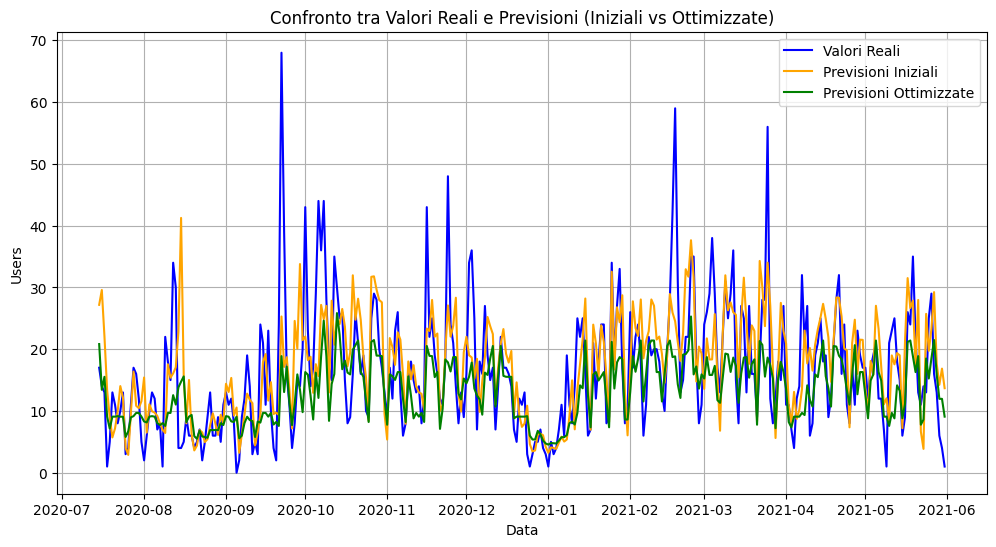

In [636]:
print("\nRisultati dopo hyperparameter tuning:")
print(f'MAE (Training): {mae_train_optimized}')
print(f'RMSE (Training): {rmse_train_optimized}')
print(f'MAE (Test): {mae_test_optimized}')
print(f'RMSE (Test): {rmse_test_optimized}')

# Confronto tra previsioni iniziali e ottimizzate
plt.figure(figsize=(12, 6))
plt.plot(y_test.index, y_test, label='Valori Reali', color='blue')
plt.plot(y_test.index, y_pred_test_initial, label='Previsioni Iniziali', color='orange')
plt.plot(y_test.index, y_pred_test_optimized, label='Previsioni Ottimizzate', color='green')
plt.xlabel('Data')
plt.ylabel('Users')
plt.title('Confronto tra Valori Reali e Previsioni (Iniziali vs Ottimizzate)')
plt.legend()
plt.grid()
plt.show()

In [637]:
# Definisci una funzione per calcolare MAE e RMSE
def calculate_losses(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    return mae, rmse

# Modello non ottimizzato
y_pred_train_non_opt = initial_model.predict(X_train)
y_pred_test_non_opt = initial_model.predict(X_test)

mae_train_non_opt, rmse_train_non_opt = calculate_losses(y_train, y_pred_train_non_opt)
mae_test_non_opt, rmse_test_non_opt = calculate_losses(y_test, y_pred_test_non_opt)

# Modello ottimizzato
y_pred_train_opt = best_model.predict(X_train)
y_pred_test_opt = best_model.predict(X_test)

mae_train_opt, rmse_train_opt = calculate_losses(y_train, y_pred_train_opt)
mae_test_opt, rmse_test_opt = calculate_losses(y_test, y_pred_test_opt)

# Stampa i risultati
print("Risultati Modello Non Ottimizzato:")
print(f"MAE (Training): {mae_train_non_opt}, RMSE (Training): {rmse_train_non_opt}")
print(f"MAE (Test): {mae_test_non_opt}, RMSE (Test): {rmse_test_non_opt}")

print("\nRisultati Modello Ottimizzato:")
print(f"MAE (Training): {mae_train_opt}, RMSE (Training): {rmse_train_opt}")
print(f"MAE (Test): {mae_test_opt}, RMSE (Test): {rmse_test_opt}")


Risultati Modello Non Ottimizzato:
MAE (Training): 2.1384834233645256, RMSE (Training): 3.299979399709748
MAE (Test): 6.332613298826129, RMSE (Test): 8.72026552352056

Risultati Modello Ottimizzato:
MAE (Training): 3.9291812647701145, RMSE (Training): 6.71882669064265
MAE (Test): 6.015057413748863, RMSE (Test): 8.84481258480841


In [638]:
# Registrazione delle metriche di loss
# Per il modello iniziale
loss_initial = {'train_rmse': [], 'test_rmse': [], 'train_mae': [], 'test_mae': []}
# Add eval_metric='mae' to track MAE during training
initial_model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)], verbose=False)
loss_initial['train_rmse'].append(initial_model.evals_result()['validation_0']['rmse'])
loss_initial['test_rmse'].append(initial_model.evals_result()['validation_1']['rmse'])
loss_initial['train_mae'].append(initial_model.evals_result()['validation_0']['mae'])
loss_initial['test_mae'].append(initial_model.evals_result()['validation_1']['mae'])

# Per il modello ottimizzato
loss_optimized = {'train_rmse': [], 'test_rmse': [], 'train_mae': [], 'test_mae': []}
# Add eval_metric='mae' to track MAE during training
best_model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)], verbose=False)
loss_optimized['train_rmse'].append(best_model.evals_result()['validation_0']['rmse'])
loss_optimized['test_rmse'].append(best_model.evals_result()['validation_1']['rmse'])
loss_optimized['train_mae'].append(best_model.evals_result()['validation_0']['mae'])
loss_optimized['test_mae'].append(best_model.evals_result()['validation_1']['mae'])

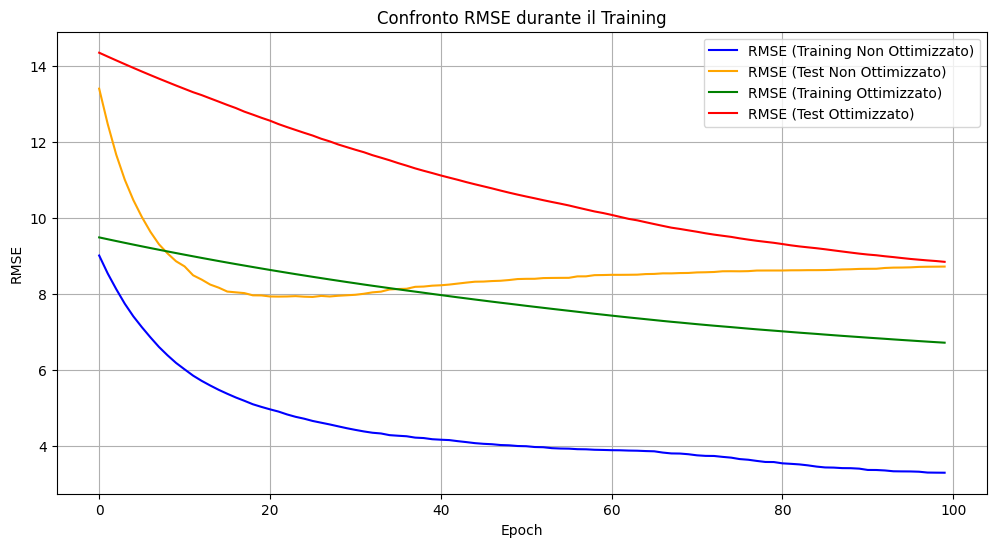

In [639]:
# Traccia i grafici delle metriche di loss per RMSE
plt.figure(figsize=(12, 6))
plt.plot(loss_initial['train_rmse'][0], label='RMSE (Training Non Ottimizzato)', color='blue')
plt.plot(loss_initial['test_rmse'][0], label='RMSE (Test Non Ottimizzato)', color='orange')
plt.plot(loss_optimized['train_rmse'][0], label='RMSE (Training Ottimizzato)', color='green')
plt.plot(loss_optimized['test_rmse'][0], label='RMSE (Test Ottimizzato)', color='red')
plt.xlabel('Epoch')
plt.ylabel('RMSE')
plt.title('Confronto RMSE durante il Training')
plt.legend()
plt.grid()
plt.show()

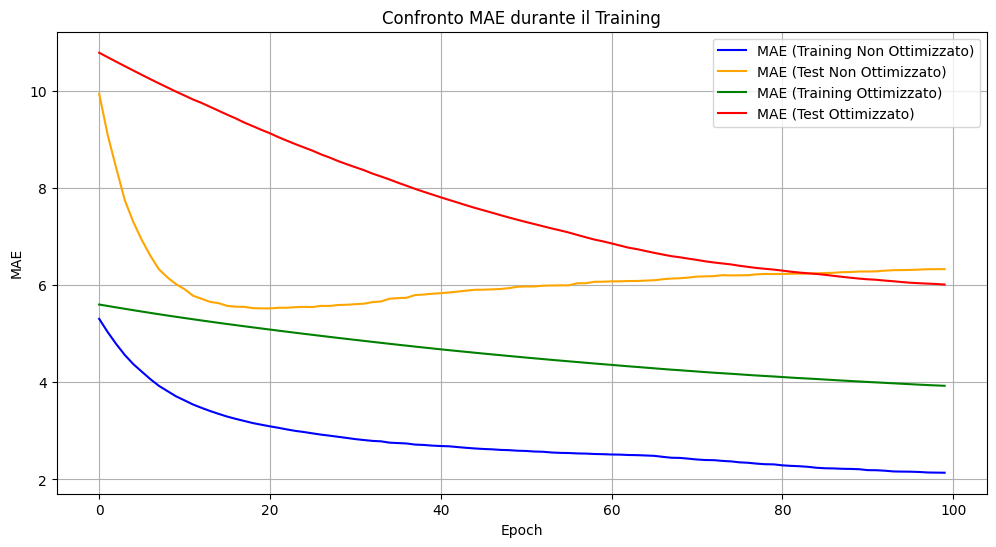

In [640]:
# Traccia i grafici delle metriche di loss per MAE
plt.figure(figsize=(12, 6))
plt.plot(loss_initial['train_mae'][0], label='MAE (Training Non Ottimizzato)', color='blue')
plt.plot(loss_initial['test_mae'][0], label='MAE (Test Non Ottimizzato)', color='orange')
plt.plot(loss_optimized['train_mae'][0], label='MAE (Training Ottimizzato)', color='green')
plt.plot(loss_optimized['test_mae'][0], label='MAE (Test Ottimizzato)', color='red')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.title('Confronto MAE durante il Training')
plt.legend()
plt.grid()
plt.show()

## Considerazioni finali sul modello

### 1. Modello non ottimizzato
- **MAE (Training):** 2.138
- **RMSE (Training):** 3.299
- **MAE (Test):** 6.332
- **RMSE (Test):** 8.720

Il modello non ottimizzato presenta **MAE e RMSE sul training set significativamente più bassi rispetto al test set**, il che suggerisce che il modello stia sovra-adattando i dati di training. Questo è un chiaro segnale di **overfitting**: il modello impara troppo bene i pattern del training set e non riesce a generalizzare altrettanto bene sui dati di test.

---

### 2. Modello ottimizzato
- **MAE (Training):** 3.929
- **RMSE (Training):** 6.718
- **MAE (Test):** 6.015
- **RMSE (Test):** 8.844

Dopo l'ottimizzazione degli iperparametri, si nota un avvicinamento tra le prestazioni sul training set e sul test set:
- Il **MAE sul training set** è aumentato (da 2.138 a 3.929), indicando che il modello ha smesso di adattarsi troppo ai dati di training.
- Il **MAE sul test set** è migliorato leggermente (da 6.332 a 6.015), con una **stabilità nelle metriche RMSE**.

---

### 3. Overfitting vs Underfitting

- **Overfitting:** Il modello non ottimizzato mostra segni evidenti di overfitting, con una grande differenza tra le prestazioni sul training set e sul test set. Questo significa che il modello si adatta troppo ai dati di training e fatica a generalizzare su dati mai visti.
  
- **Modello ottimizzato:** Dopo il tuning degli iperparametri, il modello appare meno soggetto a overfitting, grazie al ridotto scarto tra le prestazioni sui due set. Tuttavia, il miglioramento complessivo sul test set è stato marginale, suggerendo che il problema potrebbe non essere solo nell'ottimizzazione del modello.

- **Underfitting:** Non sembrano esserci segnali di underfitting, poiché il modello ottimizzato non ha peggiorato drasticamente le prestazioni né ha sottostimato i pattern presenti nei dati.

---

### 4. Prossimi passi
- **Feature engineering:** Esplorare nuove feature o migliorare quelle esistenti potrebbe aiutare a migliorare le prestazioni del modello.
- **Più dati:** Aumentare il volume di dati a disposizione può migliorare la capacità di generalizzazione.
- **Tuning avanzato:** Valutare tecniche di tuning avanzate come la **Bayesian Optimization** o la **Random Search** potrebbe ottimizzare ulteriormente il modello.

In conclusione, dopo il tuning, il modello appare più bilanciato e meno incline all'overfitting, ma ci sono margini di miglioramento soprattutto nell'analisi delle feature e nell'aumento dei dati disponibili.
